Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 15-May-2025

In [1]:
import pandas as pd
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

In [2]:
# Set data directory 
data_dir = r'Z:/Data/Roadrunner/CsChrimson_arena/'

In [3]:
# Set parameters
sampling_rate = 20 # Hz
filter_size = 0.2 # s

In [4]:
# Load data
# Positive angular velocity corresponds to counterclockwise turning
df = pd.read_csv(data_dir+'roadrunner_sparc.csv') 
df

,set,intensity,animal_id,frame,time,n_stimulus,x,y,forward_velocity,lateral_velocity,angular_velocity,speed
0,Bilateral,9,1,1,0.05,0,71.1,40.2,0.000000,0.000000,0.000000,0.0
1,Bilateral,9,1,2,0.10,0,71.1,40.2,0.000000,0.000000,-45.210038,0.0
2,Bilateral,9,1,3,0.15,0,71.1,40.2,0.000000,0.000000,45.210038,0.0
3,Bilateral,9,1,4,0.20,0,71.1,40.2,0.000000,0.000000,-15.696492,0.0
4,Bilateral,9,1,5,0.25,0,71.1,40.2,-1.086503,-1.679140,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
455395,Right,9,33,13796,689.80,0,55.5,85.8,-0.124035,0.992278,6.127832,1.0
455396,Right,9,33,13797,689.85,0,55.5,85.9,0.000000,0.000000,0.000000,0.0
455397,Right,9,33,13798,689.90,0,55.5,85.8,0.124035,-0.992278,0.000000,1.0
455398,Right,9,33,13799,689.95,0,55.5,85.8,-0.124035,0.992278,0.000000,1.0


In [5]:
# Pool time courses for a given intensity
parameter_name = "forward_velocity" 
sets = ['Bilateral']
intensity = 9
stimulus_duration = 10 # s
pre_duration = 5 # s
post_duration = 5 # s

# Initialize variables
df_sub = df[(df.intensity==intensity) & (df.set.isin(sets))]
animal_ids = df_sub.animal_id.unique().tolist()
n_animals = len(animal_ids)
mean_parameters = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(animal_ids)))
mean_intensities = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(animal_ids)))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):
    n_stimulus = df_sub.n_stimulus[df_sub.animal_id==animal_id].to_numpy()
    intensity = df_sub.intensity[df_sub.animal_id==animal_id].to_numpy()
    parameter = df_sub[parameter_name][df_sub.animal_id==animal_id].to_numpy()   

    # Flip angular velocity for set 'Right'
    if parameter_name=='angular_velocity' and df_sub.set[df_sub.animal_id==animal_id].unique().item()=='Right': 
        parameter = parameter*-1
    
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    
    mean_parameter = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(stimulus_onset_indices)))
    mean_intensity = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(stimulus_onset_indices))) 

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]-pre_duration*sampling_rate
        offset = stimulus_onset_indices[index][0]+(stimulus_duration+post_duration)*sampling_rate
        mean_parameter[:,index] = ndimage.median_filter(parameter[onset:offset], size=int(filter_size*sampling_rate))
        mean_intensity[:,index] = intensity[onset:offset]
        
    mean_parameters[:,animal_id_index] = np.nanmean(mean_parameter,axis=1) 
    mean_intensities[:,animal_id_index] = np.nanmean(mean_intensity,axis=1) 

In [6]:
n_animals

5

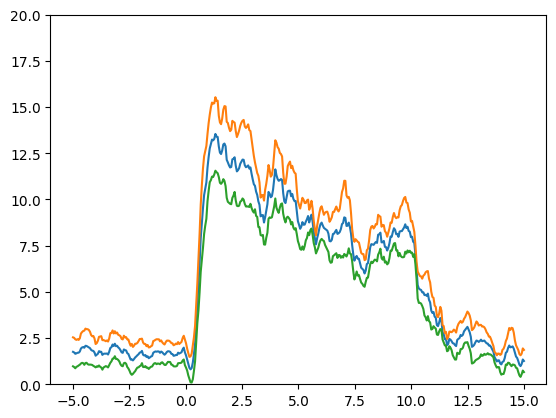

In [7]:
# Plot mean time course
time = time = np.linspace(-pre_duration, stimulus_duration+post_duration, num=(pre_duration+stimulus_duration+post_duration)*sampling_rate)
mean = np.mean(mean_parameters,axis=1)
sem = np.std(mean_parameters,axis=1)/np.sqrt(np.size(mean_parameters,1))

plt.plot(time,mean)
plt.plot(time,mean+sem)
plt.plot(time,mean-sem)
plt.ylim([0,20])
#plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [25]:
# Calculate mean speed during activation for each animal and intensity
parameter_name = "angular_velocity"
sets = ['Right','Left']

# Initialize variables 
df_sub = df[df.set.isin(sets)] 
n_animals = len(df_sub.animal_id.unique().tolist())
intensities = df_sub.intensity.unique().tolist() 
mean_parameters = np.empty((n_animals,len(intensities)))
mean_parameters[:] = np.nan

# Loop over intensities
for intensity_index, intensity in enumerate(intensities):
    animal_ids = df_sub.animal_id[df_sub.intensity==intensity].unique().tolist()

    # Loop over animals
    for animal_id_index, animal_id in enumerate(animal_ids):
        parameter = df_sub[parameter_name][(df_sub.animal_id==animal_id) & (df_sub.n_stimulus!=0)].to_numpy()
        parameter = ndimage.median_filter(parameter, size=int(filter_size*sampling_rate))

        # Flip angular velocity for set 'Right'
        if parameter_name=='angular_velocity' and df_sub.set[df_sub.animal_id==animal_id].unique().item()=='Right': 
            parameter = parameter*-1
        
        parameter = np.mean(parameter)

        mean_parameters[animal_id_index,intensity_index] = parameter

In [26]:
n_animals

12

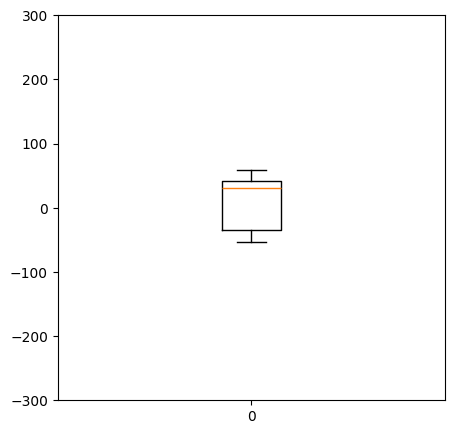

In [28]:
# Plot speed
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(mean_parameters, positions=range(len(intensities)))
ax.set_ylim(-300,300)
# plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [38]:
# Calculate mean speed for each animal and repetition for a specific intensity
parameter_name = 'speed'
sets = ['Right','Left']
intensity = 9
stimulus_duration = 10 # s

# Initialize variables
df_sub = df[(df.intensity==intensity) & (df.set.isin(sets))]
animal_ids = df_sub.animal_id.unique().tolist()
n_animals = len(animal_ids)
n_stimulus_presentations = len(df_sub.n_stimulus[df_sub.n_stimulus!=0].unique().tolist())
mean_parameters = np.zeros((n_animals, n_stimulus_presentations))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):
    n_stimulus = df_sub.n_stimulus[df_sub.animal_id==animal_id].to_numpy()
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    parameter = df_sub[parameter_name][df_sub.animal_id==animal_id].to_numpy()
    
    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]
        offset = stimulus_onset_indices[index][0]+stimulus_duration*sampling_rate
        mean_parameters[animal_id_index,index] = np.mean(ndimage.median_filter(parameter[onset:offset], size=int(filter_size*sampling_rate)))

In [32]:
n_animals

12

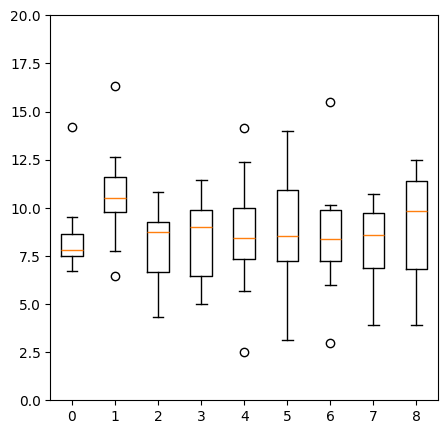

In [39]:
# Plot speed over stimulus repetitions
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(mean_parameters, positions=range(len(stimulus_onset_indices)))
ax.set_ylim(0,20)
# plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

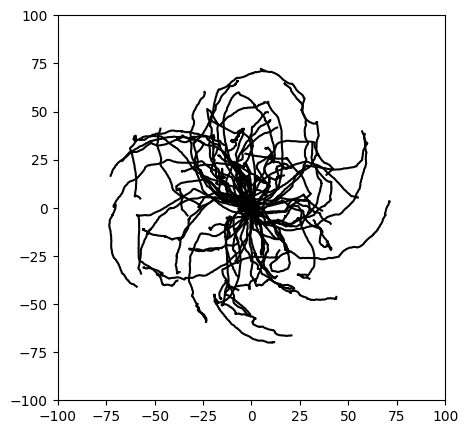

In [41]:
# Plot trajectories for an intensity 
# Note: Different sets can have different absolute x/y values. Plot separately.
intensity = 9
sets = ['Left']
subtract_origin = True
stimulus_duration = 10 # s

# Initialize variables
df_sub = df[(df.intensity==intensity) & (df.set.isin(sets))] 
animal_ids = df_sub.animal_id.unique().tolist()
fig, ax = plt.subplots(figsize=(5, 5))

# Loop over animals
for animal_id in animal_ids:
    x = df_sub["x"][(df_sub.animal_id==animal_id)].to_numpy() 
    y = df_sub["y"][(df_sub.animal_id==animal_id)].to_numpy() 
    n_stimulus = df_sub["n_stimulus"][(df_sub.animal_id==animal_id)].to_numpy() 
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    
    onset = stimulus_onset_indices[0][0]

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]
        offset = onset+(stimulus_duration)*sampling_rate

        if subtract_origin:
            ax.plot(x[onset:offset]-x[onset], y[onset:offset]-y[onset], color=[0,0,0])
        else:
            ax.plot(x[onset:offset], y[onset:offset], color=[0,0,0])

if subtract_origin:
    lim = [-100,100]
else: 
    lim = [0,100]
    
ax.set_xlim(lim)
ax.set_ylim(lim)
# plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()